In [1]:
%load_ext autoreload
%autoreload 2
from dnafiber.data.dataset import FiberDatamodule
from nntools.utils import Config
import pandas as pd

/home/clement/miniforge-pypy3/envs/dl/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/clement/miniforge-pypy3/envs/dl/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
c = Config("../configs/config.yaml")
c["data"]["sato_filter"] = False
c["data"]["crop_size"] = None
datamodule = FiberDatamodule(**c["data"], polar_space=False)
datamodule.setup()



In [5]:
dataloader = datamodule.test_dataloader()
dataloader

In [4]:
from dnafiber.deployment import _get_model, MODELS_ZOO
from tqdm.auto import tqdm
import torch

all_scores = []
for key, model_name in MODELS_ZOO.items():
    if model_name.lower() == 'ensemble':
        continue
    model = _get_model(f"{model_name}_finetuned")

    model = model.cuda()
    model.eval()
    metric = model.metric
    for batch in tqdm(dataloader, total=len(dataloader)):
        images = batch["image"].cuda()
        gt = batch["mask"].cuda()
        print(gt.max(), gt.min())
        with torch.no_grad():
            pred = model(images)
            proba = torch.softmax(pred, dim=1)


        metric.update(proba, gt)
    scores = metric.compute()
    scores["model"] = key

    for k, v in scores.items():
        if isinstance(v, torch.Tensor):
            scores[k] = v.item()
    all_scores.append(scores)


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(2, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(2, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(2, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(2, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(2, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(2, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(9, device='cuda:0', dtype=torch.uint8) tensor(0, device='cuda:0', dtype=torch.uint8)


Exception ignored in: <function _ConnectionBase.__del__ at 0x7331af18ca40>
Traceback (most recent call last):
  File "/home/clement/miniforge-pypy3/envs/dl/lib/python3.11/multiprocessing/connection.py", line 133, in __del__
    self._close()
  File "/home/clement/miniforge-pypy3/envs/dl/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


ValueError: The highest label in `target` should be smaller than the size of the `C` dimension of `preds`.

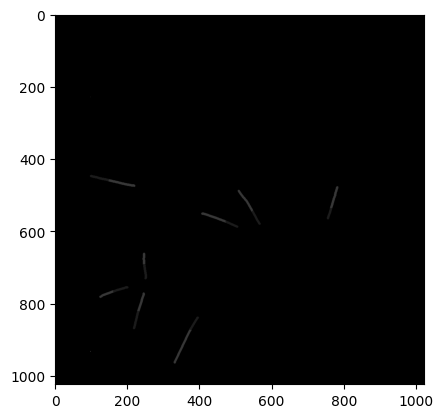

In [19]:
import matplotlib.pyplot as plt


plt.imshow(gt[12].cpu().numpy())

In [16]:
gt.flatten(1).max(dim=1).values.argmax()

tensor(12, device='cuda:0')

In [ ]:
for k, v in scores.items():
    if isinstance(v, torch.Tensor):
        scores[k] = v.item()

In [ ]:
df = pd.DataFrame(all_scores)
df

,detection_precision,detection_recall,fiber_red_dice,fiber_green_dice,fiber_red_recall,fiber_green_recall,fiber_red_precision,fiber_green_precision,total_real_fibers,total_predicted_fibers,dice,jaccard,model
0,0.500000,0.763889,0.801966,0.820294,0.806450,0.820593,0.946646,0.974891,1080,1650,0.573949,0.619052,jaccard
1,0.450079,0.001082,0.817008,0.812679,0.809454,0.804872,0.945312,0.966376,787501,264022,0.562234,0.621740,jaccard


In [ ]:
from pathlib import Path
import numpy as np

root_clement = Path(
    "/home/clement/Documents/data/DNAFiber/Intergraders/Santiago/common/"
)
imgs_clement = list(root_clement.rglob("*.png"))
imgs_hugo = list(
    Path("/home/clement/Documents/data/DNAFiber/Intergraders/Yosra/common/").rglob(
        "*.png"
    )
)


def read_mask(path):
    import cv2

    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)[:, :, ::-1]  # BGR to RGB
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[img[:, :, 0] > 200] = 1
    mask[img[:, :, 1] > 200] = 2
    return mask[np.newaxis, ...]


imgs_clement = (
    torch.from_numpy(np.asarray([read_mask(p) for p in imgs_clement])).squeeze().cuda()
)
imgs_hugo = (
    torch.from_numpy(np.asarray([read_mask(p) for p in imgs_hugo])).squeeze().cuda()
)
metrics = model.metric.clone()
metrics.reset()

metrics.update(imgs_clement, imgs_hugo)
metrics.compute()

{'detection_precision': tensor(0.6757, device='cuda:0'),
 'detection_recall': tensor(0.5814, device='cuda:0'),
 'fiber_red_dice': tensor(0.7543, device='cuda:0'),
 'fiber_green_dice': tensor(0.7711, device='cuda:0'),
 'fiber_red_recall': tensor(0.7435, device='cuda:0'),
 'fiber_green_recall': tensor(0.7906, device='cuda:0'),
 'fiber_red_precision': tensor(0.9463, device='cuda:0'),
 'fiber_green_precision': tensor(0.9416, device='cuda:0'),
 'total_real_fibers': 129,
 'total_predicted_fibers': 111,
 'dice': tensor(0.4727, device='cuda:0'),
 'jaccard': tensor(0.4366, device='cuda:0')}

In [ ]:
imgs_hugo.shape

torch.Size([0])